# Part 3: Predictive Modelling 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl



import itertools, time, datetime

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [4]:
df = pd.read_csv('/Users/santoshmanne/Desktop/Credit-Card-Payment-Default/cleaned_data.csv')
pd.set_option('display.max_columns', None)

In [5]:
df.shape

(26664, 30)

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,university,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,university,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,university,0,0,0,1
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,university,0,0,0,1
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,university,0,0,0,1


In [7]:
features_response = df.columns.tolist()

In [8]:
features_response[:7]

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1']

In [9]:
features_response[-5:]

['EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university']

In [10]:
items_to_remove = ['ID', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [11]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

Univariate feature selection using ANOVA F-test and P-values to examine the relationshiop between features and response. The first step will be to seperate the features and response into two individual numpy arrays as listed below.

In [12]:
X = df[features_response].iloc[:,:-1].values
y = df[features_response].iloc[:,-1].values
print(X.shape, y.shape)

(26664, 18) (26664,)


In [15]:
# Creating a dataframe which compares the features to their respective F-test and P-test scores.
[f_stat, f_p_value] = f_classif(X, y)
f_test_df = pd.DataFrame({'Feature':features_response[:-1],
'F statistic':f_stat,
'p value':f_p_value})
f_test_df.sort_values('p value')


,Feature,F statistic,p value
5,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
12,PAY_AMT1,140.612679,2.358354e-32
13,PAY_AMT2,101.408321,8.256124e-24
14,PAY_AMT3,90.023873,2.542641e-21
16,PAY_AMT5,85.843295,2.090120e-20
17,PAY_AMT6,80.420784,3.219565e-19
15,PAY_AMT4,79.640021,4.774112e-19
1,SEX,42.610039,6.801534e-11
2,EDUCATION,32.637768,1.122175e-08


In [16]:
corr = df[features_response].corr()
corr

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
LIMIT_BAL,1.000000,0.027046,-0.232688,-0.111873,0.149157,-0.273396,0.287009,0.279289,0.285299,0.294342,0.295198,0.289818,0.194820,0.188049,0.207638,0.202795,0.218082,0.221305,-0.154423
SEX,0.027046,1.000000,0.014336,-0.031307,-0.088421,-0.058993,-0.032336,-0.029682,-0.023217,-0.019970,-0.015168,-0.014406,0.002964,-0.002285,-0.011542,-0.000199,0.000081,-0.003342,-0.039945
EDUCATION,-0.232688,0.014336,1.000000,-0.137097,0.179035,0.112653,0.016156,0.012307,0.007683,-0.005862,-0.013174,-0.012670,-0.040092,-0.033610,-0.042349,-0.039319,-0.044946,-0.046859,0.034966
MARRIAGE,-0.111873,-0.031307,-0.137097,1.000000,-0.412828,0.019759,-0.028610,-0.026009,-0.029192,-0.027740,-0.029895,-0.024414,-0.002951,-0.007548,-0.003408,-0.014387,-0.000410,-0.009461,-0.026030
AGE,0.149157,-0.088421,0.179035,-0.412828,1.000000,-0.044277,0.056245,0.054099,0.054107,0.051241,0.049701,0.047519,0.025437,0.025421,0.029876,0.025307,0.020541,0.021640,0.014334
PAY_1,-0.273396,-0.058993,0.112653,0.019759,-0.044277,1.000000,0.185826,0.188799,0.181257,0.178812,0.180438,0.177486,-0.081450,-0.073295,-0.072682,-0.064112,-0.057021,-0.061031,0.325365
BILL_AMT1,0.287009,-0.032336,0.016156,-0.028610,0.056245,0.185826,1.000000,0.951651,0.900386,0.860149,0.828615,0.802008,0.138221,0.112460,0.145635,0.160204,0.163425,0.178943,-0.020508
BILL_AMT2,0.279289,-0.029682,0.012307,-0.026009,0.054099,0.188799,0.951651,1.000000,0.937488,0.892103,0.858078,0.830300,0.276583,0.114473,0.137514,0.148685,0.153851,0.172472,-0.014579
BILL_AMT3,0.285299,-0.023217,0.007683,-0.029192,0.054107,0.181257,0.900386,0.937488,1.000000,0.930385,0.889186,0.855154,0.242809,0.287837,0.119456,0.141010,0.159446,0.178121,-0.014649
BILL_AMT4,0.294342,-0.019970,-0.005862,-0.027740,0.051241,0.178812,0.860149,0.892103,0.930385,1.000000,0.937799,0.899241,0.229123,0.217716,0.293652,0.131700,0.158633,0.171339,-0.011349


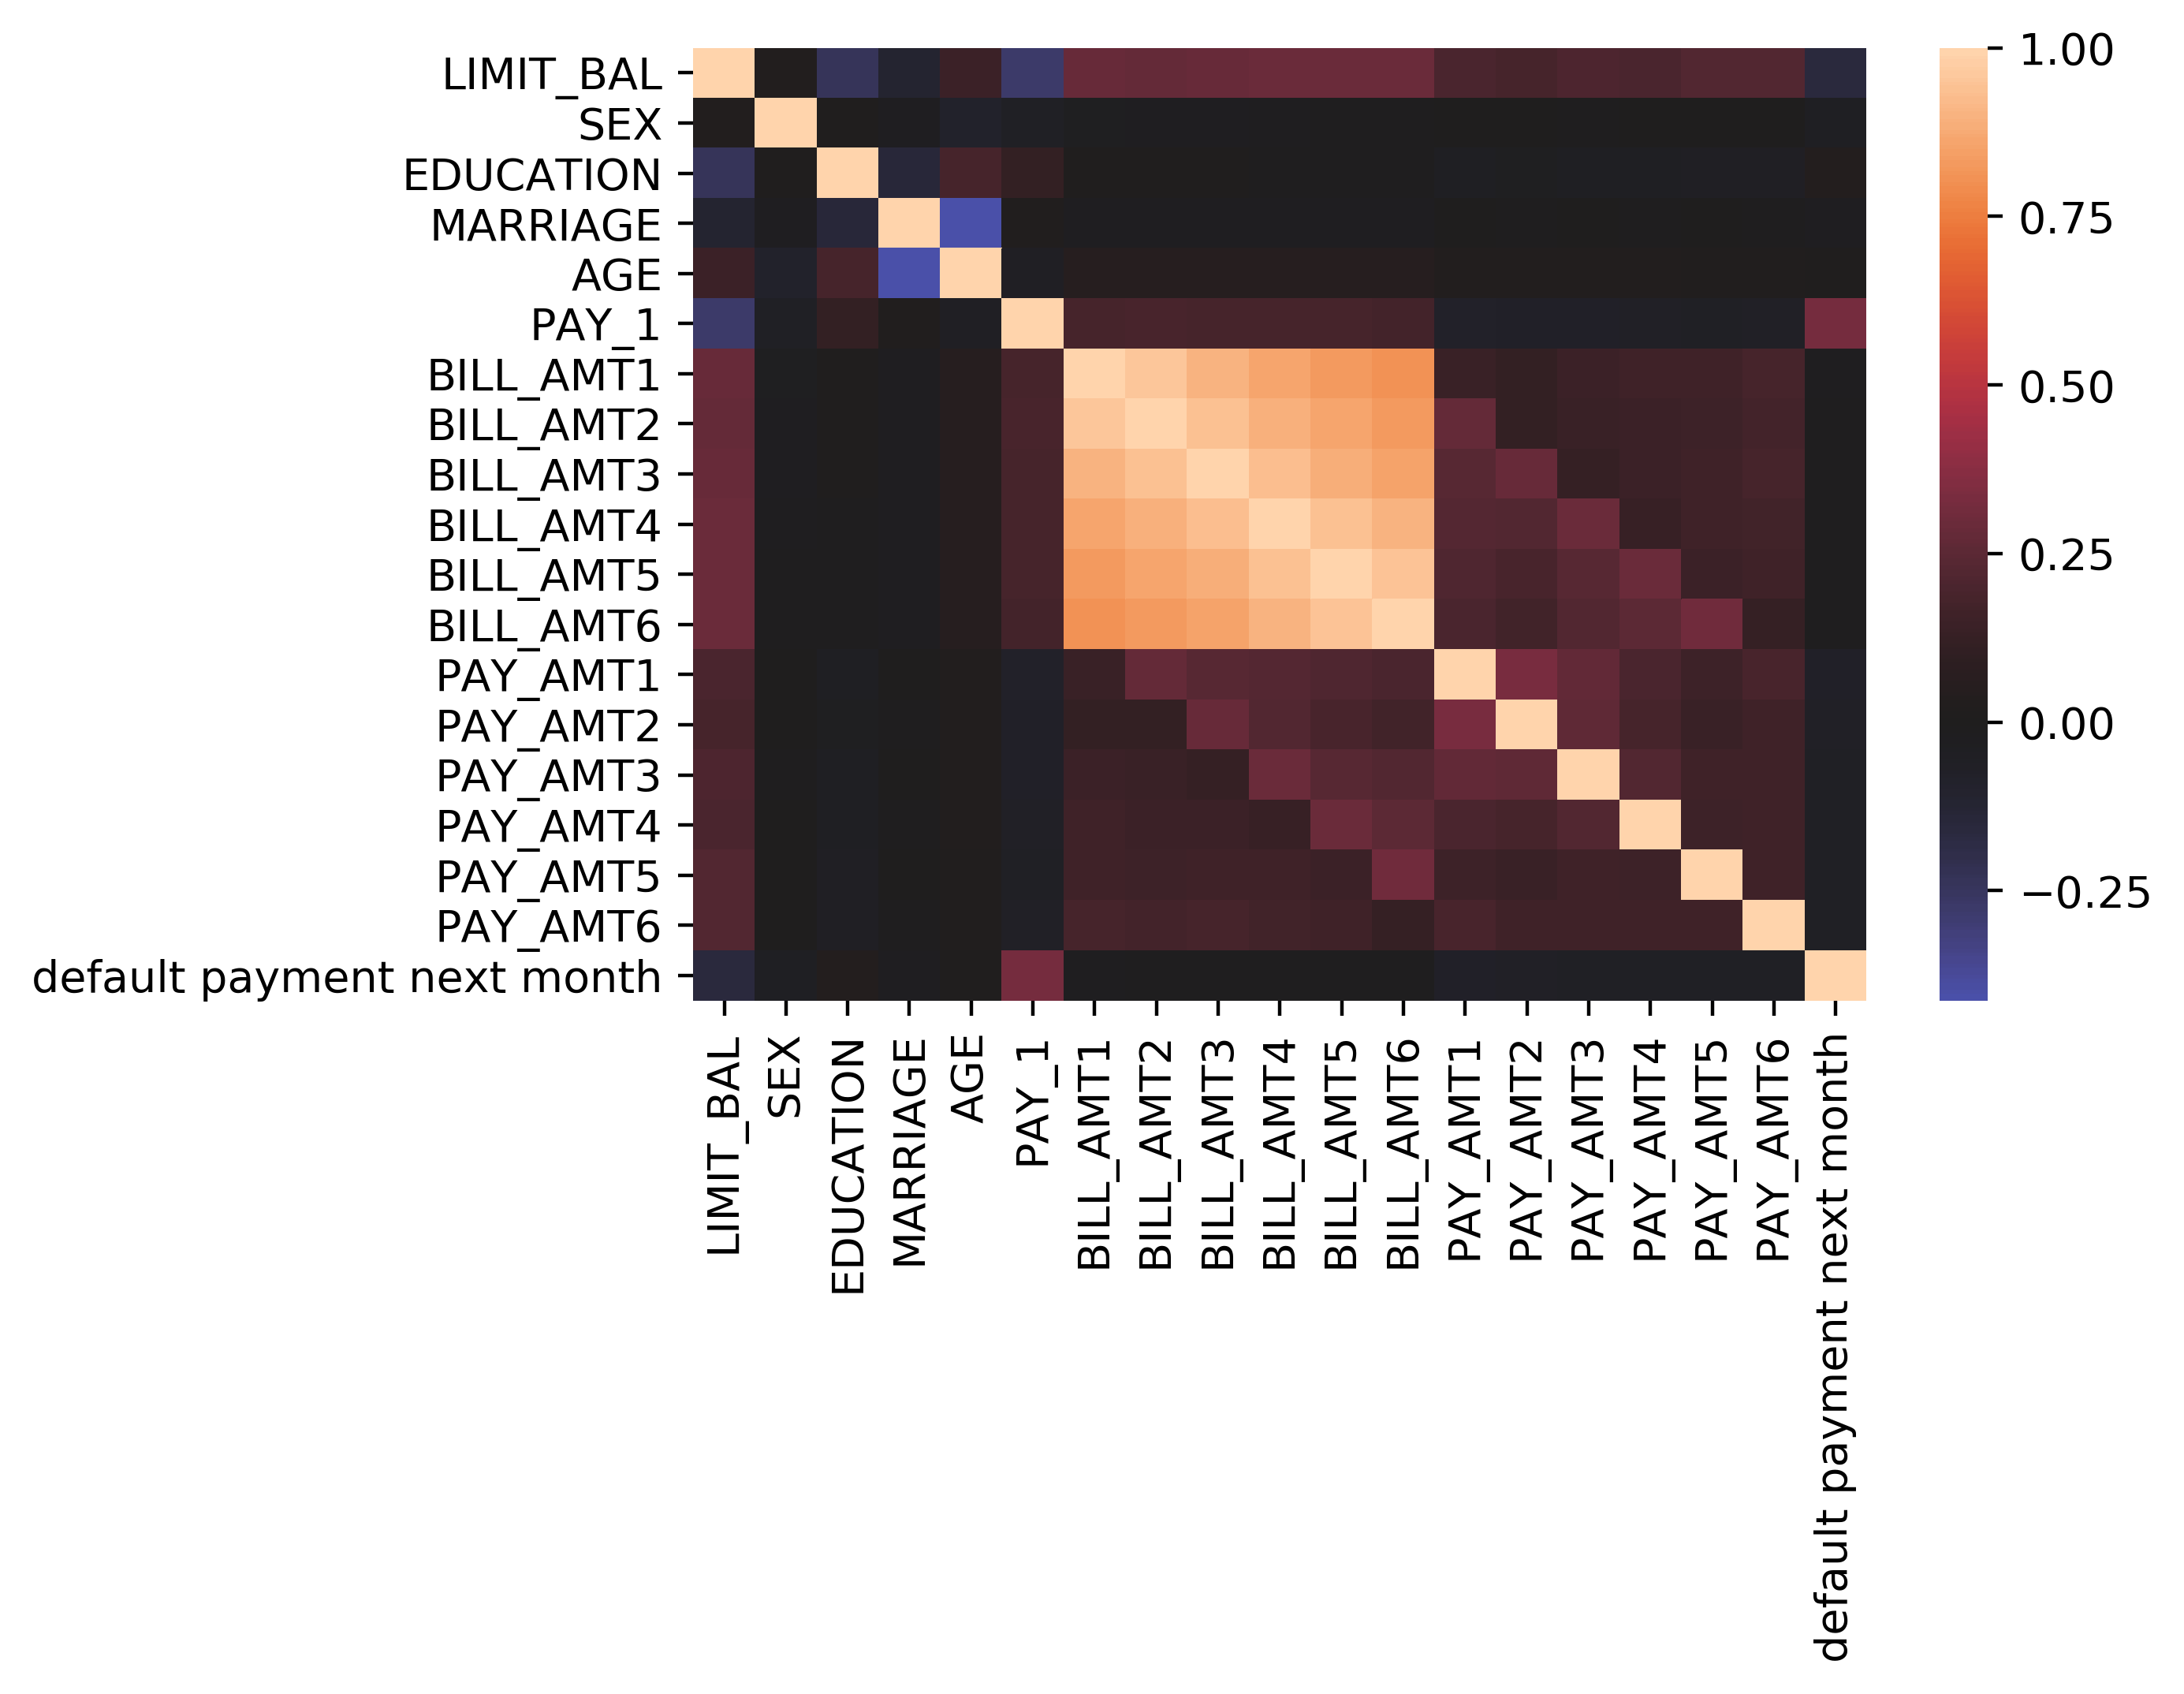

In [17]:
mpl.rcParams['figure.dpi'] = 400 #high res figures
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0)

In [26]:
target = 'default payment next month'
predictors = features_response[:-1]

In [27]:
X = df[predictors].values    
y = df[ target ].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=24)

In [29]:
scX = StandardScaler()
X_train = scX.fit_transform( X_train )
X_test = scX.transform( X_test )


- The idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.
- In case of multivariate data, this is done feature-wise (in other words independently for each column of the data).
- Given the distribution of the data, each value in the dataset will have the mean value subtracted, and then divided by the standard deviation of the whole dataset (or feature in the multivariate case).

In [31]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit( X_train, y_train )
y_pred = classifier.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for RandomForest = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresRF = cross_val_score( classifier, X_train, y_train, cv=10)
print("Mean RandomForest CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresRF.mean(), scoresRF.std() ))
MCC = matthews_corrcoef(y_test, y_pred)
print ("Matthews Correlation Cofficient = %.2f" % (MCC))
print(cm)
print(classification_report(y_test, y_pred))

Accuracy on Test Set for RandomForest = 0.81
Mean RandomForest CrossVal Accuracy on Train Set 0.81, with std=0.01
Matthews Correlation Cofficient = 0.33
[[3943  235]
 [ 803  352]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4178
           1       0.60      0.30      0.40      1155

    accuracy                           0.81      5333
   macro avg       0.72      0.62      0.64      5333
weighted avg       0.78      0.81      0.78      5333



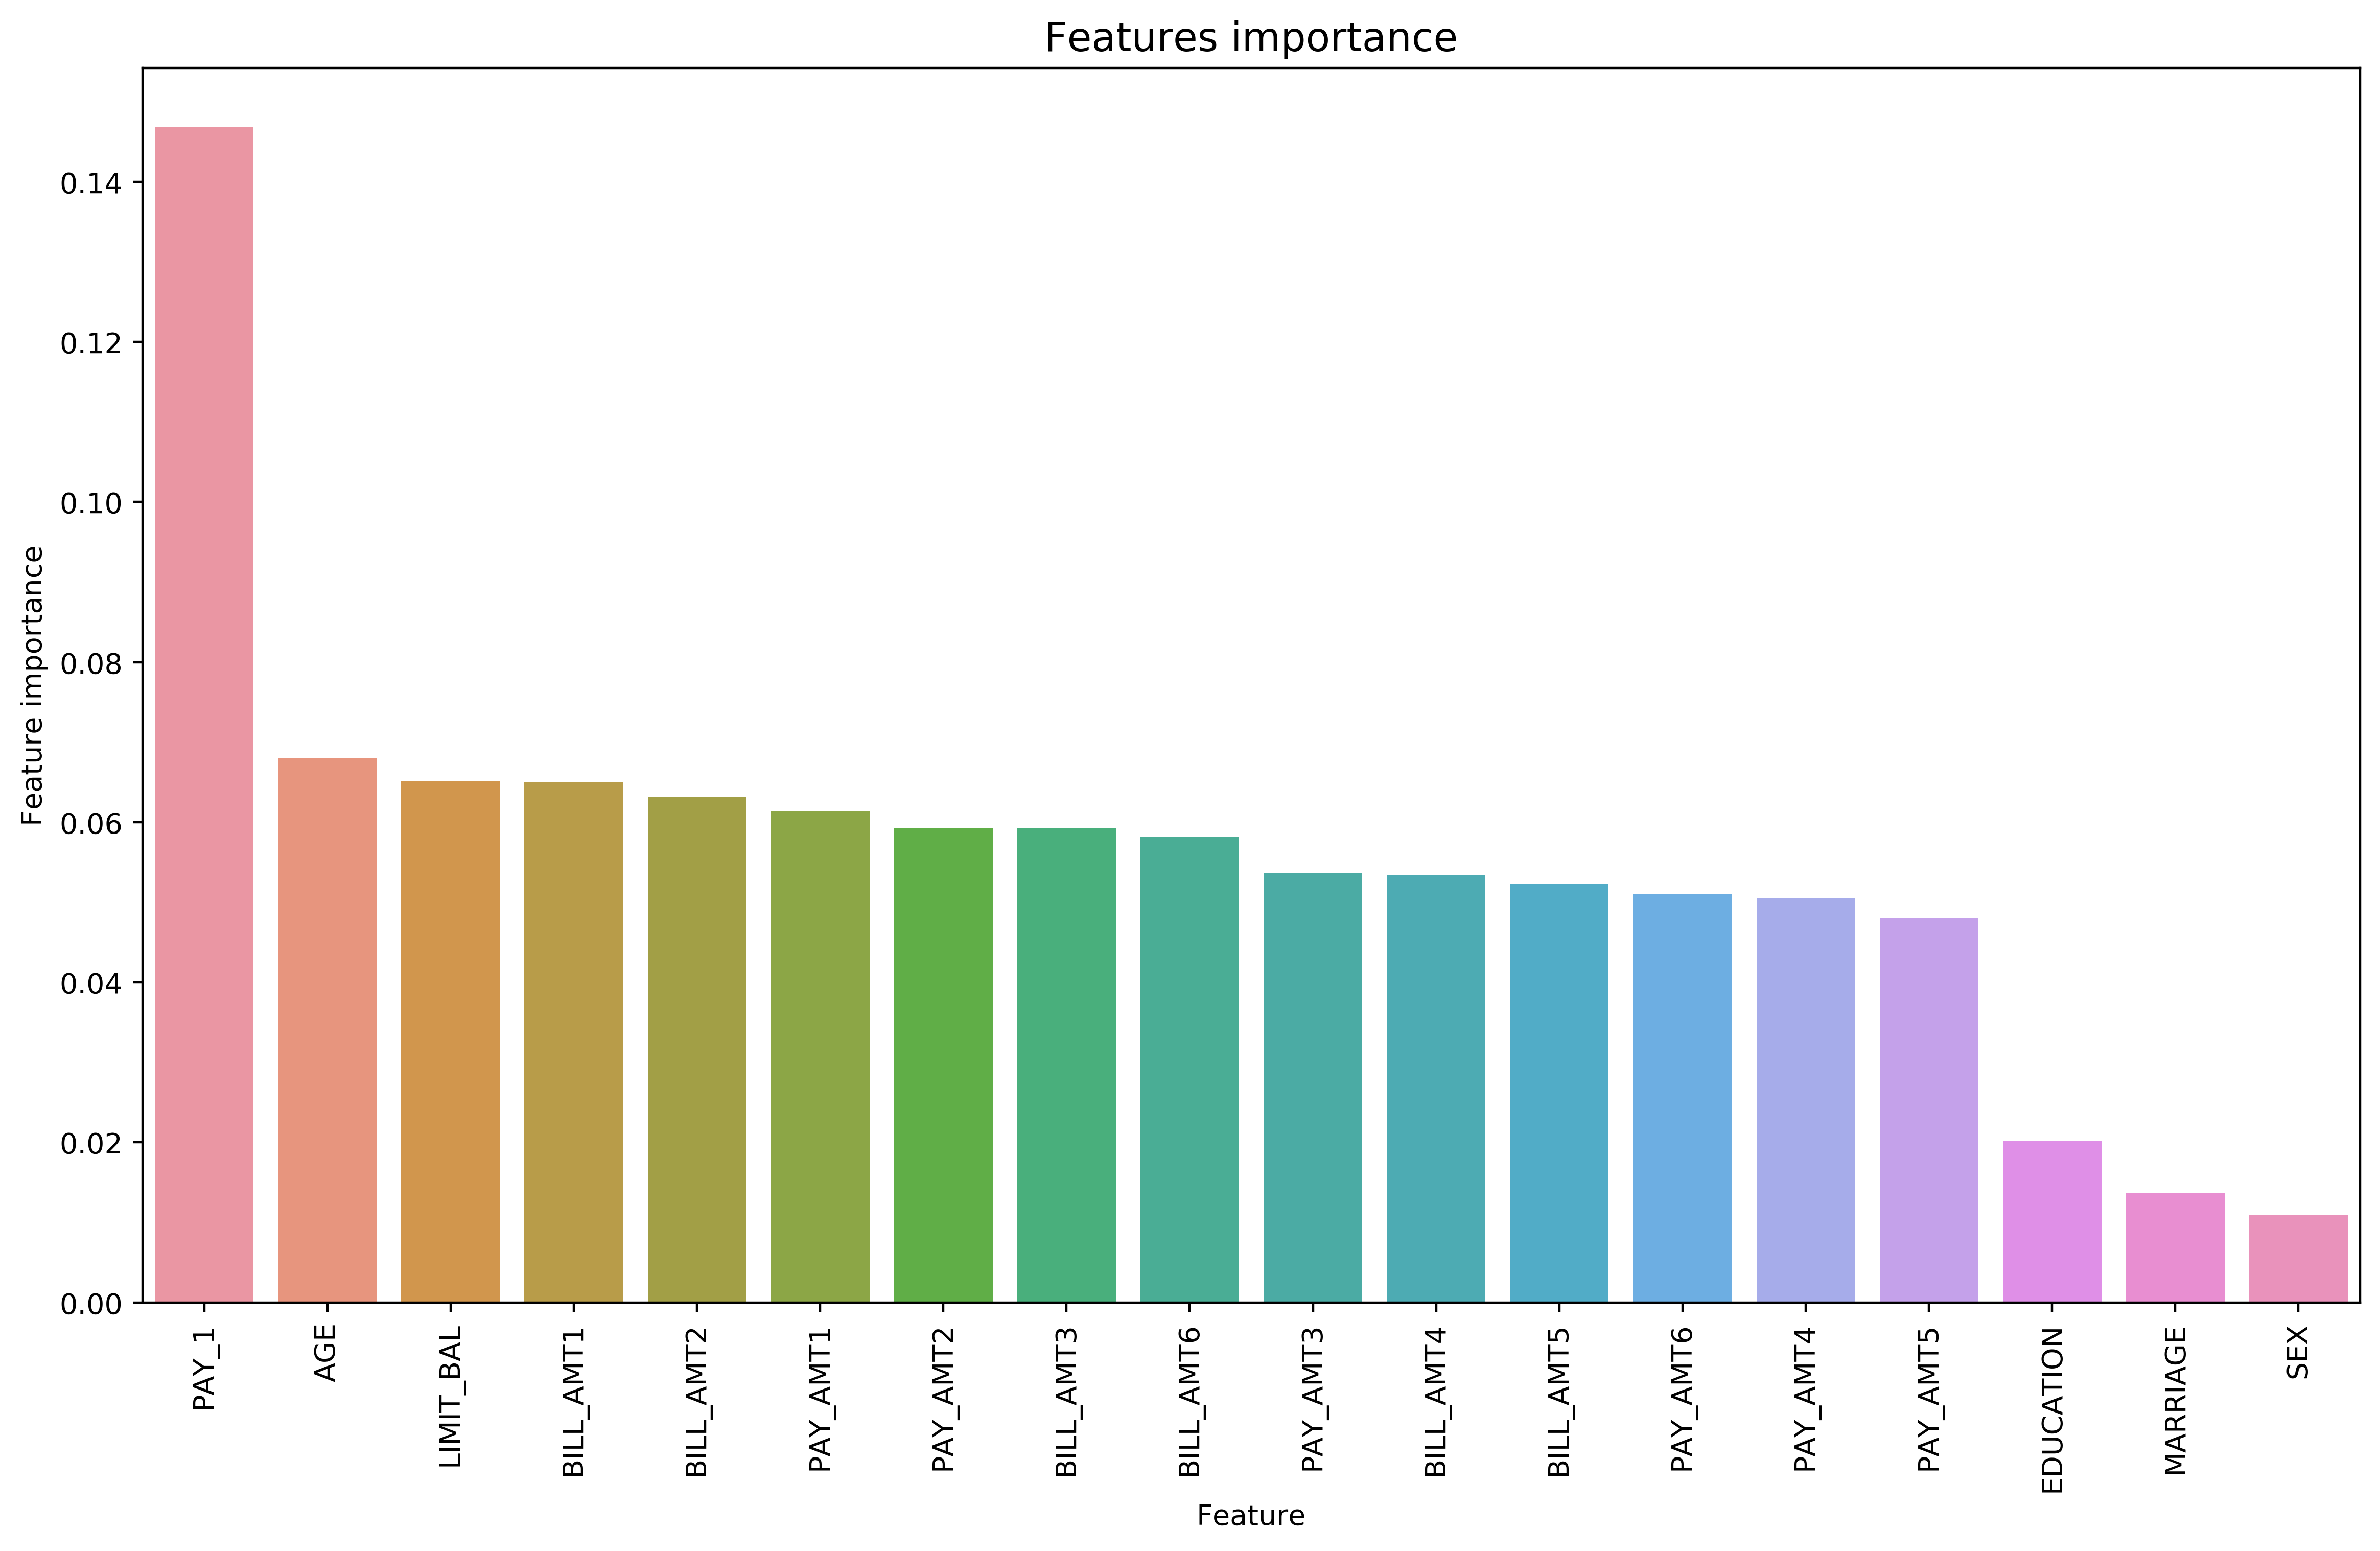

In [32]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': classifier.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (14,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [33]:
# kernel SVM 

from sklearn.svm import SVC
classifier1 = SVC(kernel="rbf")
classifier1.fit( X_train, y_train )
y_pred = classifier1.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for kernel-SVM = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresSVC = cross_val_score( classifier1, X_train, y_train, cv=10)
print("Mean kernel-SVM CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresSVC.mean(), scoresSVC.std() ))
MCC1 = matthews_corrcoef(y_test, y_pred)
print ("Matthews Correlation Cofficient = %.2f" % (MCC1))
print(cm)
print(classification_report(y_test, y_pred))

Accuracy on Test Set for kernel-SVM = 0.82
Mean kernel-SVM CrossVal Accuracy on Train Set 0.82, with std=0.01
Matthews Correlation Cofficient = 0.37
[[4029  149]
 [ 812  343]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4178
           1       0.70      0.30      0.42      1155

    accuracy                           0.82      5333
   macro avg       0.76      0.63      0.65      5333
weighted avg       0.80      0.82      0.79      5333



In [34]:
# Logistic Regression 

from sklearn.linear_model import LogisticRegression
classifier2 = LogisticRegression(solver='liblinear')
classifier2.fit( X_train, y_train )
y_pred = classifier2.predict( X_test )

cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for LogReg = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresLR = cross_val_score( classifier2, X_train, y_train, cv=10)
print("Mean LogReg CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresLR.mean(), scoresLR.std() ))
MCC2 = matthews_corrcoef(y_test, y_pred)
print ("Matthews Correlation Cofficient = %.2f" % (MCC2))
print(cm)
print(classification_report(y_test, y_pred))


Accuracy on Test Set for LogReg = 0.81
Mean LogReg CrossVal Accuracy on Train Set 0.81, with std=0.00
Matthews Correlation Cofficient = 0.33
[[4051  127]
 [ 871  284]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4178
           1       0.69      0.25      0.36      1155

    accuracy                           0.81      5333
   macro avg       0.76      0.61      0.63      5333
weighted avg       0.79      0.81      0.78      5333



In [35]:
# Naive Bayes 

from sklearn.naive_bayes import GaussianNB
classifier3 = GaussianNB()
classifier3.fit( X_train, y_train )
y_pred = classifier3.predict( X_test )
cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for NBClassifier = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresNB = cross_val_score( classifier3, X_train, y_train, cv=10)
print("Mean NaiveBayes CrossVal Accuracy on Train Set %.2f, with std=%.2f" % (scoresNB.mean(), scoresNB.std() ))
MCC3 = matthews_corrcoef(y_test, y_pred)
print ("Matthews Correlation Cofficient = %.2f" % (MCC3))
print(cm)
print(classification_report(y_test, y_pred))


Accuracy on Test Set for NBClassifier = 0.45
Mean NaiveBayes CrossVal Accuracy on Train Set 0.45, with std=0.02
Matthews Correlation Cofficient = 0.18
[[1406 2772]
 [ 156  999]]
              precision    recall  f1-score   support

           0       0.90      0.34      0.49      4178
           1       0.26      0.86      0.41      1155

    accuracy                           0.45      5333
   macro avg       0.58      0.60      0.45      5333
weighted avg       0.76      0.45      0.47      5333



In [36]:
# K-NEIGHBOURS 

from sklearn.neighbors import KNeighborsClassifier
classifier4 = KNeighborsClassifier(n_neighbors=5)
classifier4.fit( X_train, y_train )
y_pred = classifier4.predict( X_test )
cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for KNeighborsClassifier = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresKN = cross_val_score( classifier3, X_train, y_train, cv=10)
print("Mean KN CrossVal Accuracy on Train Set Set %.2f, with std=%.2f" % (scoresKN.mean(), scoresKN.std() ))
MCC4 = matthews_corrcoef(y_test, y_pred)
print ("Matthews Correlation Cofficient = %.2f" % (MCC4))
print(cm)
print(classification_report(y_test, y_pred))

Accuracy on Test Set for KNeighborsClassifier = 0.79
Mean KN CrossVal Accuracy on Train Set Set 0.45, with std=0.02
Matthews Correlation Cofficient = 0.30
[[3835  343]
 [ 766  389]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4178
           1       0.53      0.34      0.41      1155

    accuracy                           0.79      5333
   macro avg       0.68      0.63      0.64      5333
weighted avg       0.77      0.79      0.77      5333



In [46]:
from sklearn.ensemble import AdaBoostClassifier
seed = 4
num_trees = 100
classifier5 = AdaBoostClassifier(n_estimators = num_trees, random_state = seed)
classifier5.fit(X_train, y_train)
cm = confusion_matrix( y_test, y_pred )
print("Accuracy on Test Set for AdaboostClassifier = %.2f" % ((cm[0,0] + cm[1,1] )/len(X_test)))
scoresAB = cross_val_score( classifier5, X_train, y_train, cv=10)
print("Mean AB CrossVal Accuracy on Train Set Set %.2f, with std=%.2f" % (scoresAB.mean(), scoresAB.std() ))
MCC5 = matthews_corrcoef(y_test, y_pred)
print ("Matthews Correlation Cofficient = %.2f" % (MCC5))
print(cm)
print(classification_report(y_test, y_pred))


Accuracy on Test Set for AdaboostClassifier = 0.79
Mean AB CrossVal Accuracy on Train Set Set 0.82, with std=0.01
Matthews Correlation Cofficient = 0.30
[[3835  343]
 [ 766  389]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4178
           1       0.53      0.34      0.41      1155

    accuracy                           0.79      5333
   macro avg       0.68      0.63      0.64      5333
weighted avg       0.77      0.79      0.77      5333



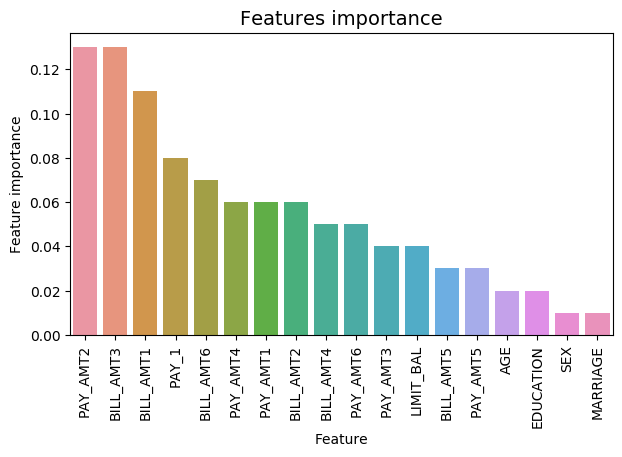

In [47]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': classifier5.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [50]:
data = [['Random Forest', MCC, 0.81, 0.81], ['Kernel SVM', MCC1, 0.82, 0.82], ['Logistic Regression', MCC2, 0.81, 0.81], ['Naive Bayes', MCC3, 0.45, 0.45], ['K-Neighbours', MCC4, 0.45, 0.79], ['Adaboost', MCC5, 0.82, 0.79]]
Final_Figures = pd.DataFrame(data, columns = ['Classifier', 'Matthews Cofficient', 'Training_set ACC', 'Testing_set ACC'])
print(Final_Figures)

            Classifier  Matthews Cofficient  Training_set ACC  Testing_set ACC
0        Random Forest             0.327073              0.81             0.81
1           Kernel SVM             0.371942              0.82             0.82
2  Logistic Regression             0.332821              0.81             0.81
3          Naive Bayes             0.182345              0.45             0.45
4         K-Neighbours             0.304875              0.45             0.79
5             Adaboost             0.304875              0.82             0.79


# CONCLUSION

We can see that the accuracy for __Kernel SVM is 0.82__, which is higher than the other models. Moreover, the accuracy scores between the train and test data are same which indicates that there is neither overfitting or underfitting. Since this dataset is imbalanced, it is good to take into consideration the Matthews Correlation Coefficient. This score of __0.33__ is also the highest for __Kernel SVM__. Hence we can conclude that Kernel SVM is the best model that we recommend. Next to be considered is Logistic Regression.